<img style="float: left;padding: 1.3em" src="https://indico.in2p3.fr/event/18313/logo-786578160.png">  

#  Gravitational Wave Open Data Workshop #2


## Tutorial 2.1 PyCBC Tutorial, An introduction to matched-filtering

We will be using the [PyCBC](http://github.com/ligo-cbc/pycbc) library, which is used to study gravitational-wave data, find astrophysical sources due to compact binary mergers, and study their parameters. These are some of the same tools that the LIGO and Virgo collaborations use to find gravitational waves in LIGO/Virgo data 

In this tutorial we will walk through how find a specific signal in LIGO data. We present matched filtering in PyCBC, which is optimal in the case of Gaussian noise and a known signal model. In reality our noise is not entirely Gaussian, and in practice we use a variety of techniques to separate signals from noise in addition to the use of the matched filter. 

[Click this link to view this tutorial in Google Colaboratory](https://colab.research.google.com/github/gw-odw/odw-2019/blob/master/Day_2/Tuto_2.1_Matched_filtering_introduction.ipynb)

Additional [examples](http://pycbc.org/pycbc/latest/html/#library-examples-and-interactive-tutorials) and module level documentation are [here](http://pycbc.org/pycbc/latest/html/py-modindex.html)

## Installation (execute only if running on a cloud platform!)

In [1]:
import sys
# !curl --silent --output requirements.txt https://raw.githubusercontent.com/gw-odw/odw-2019/master/requirements.txt
# !{sys.executable} -m pip install -q -r requirements.txt
!{sys.executable} -m pip install astropy healpy gwpy gwosc lalsuite ligo-common pycbc bilby  --no-cache-dir
print("Python version = ",sys.version)
! pip show numpy scipy astropy healpy gwpy gwosc lalsuite ligo-common pycbc bilby


     |████████████████████████████████| 11.8MB 2.7MB/s 
     |████████████████████████████████| 1.4MB 52.0MB/s 
     |████████████████████████████████| 28.5MB 1.2MB/s 
     |████████████████████████████████| 3.1MB 65.6MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 1.5MB 48.7MB/s 
     |████████████████████████████████| 51kB 42.5MB/s 
     |████████████████████████████████| 1.6MB 47.3MB/s 
     |████████████████████████████████| 798kB 58.6MB/s 
     |████████████████████████████████| 471kB 60.4MB/s 
     |████████████████████████████████| 92kB 65.3MB/s 
     |████████████████████████████████| 61kB 55.6MB/s 
     |████████████████████████████████| 2.3MB 49.4MB/s 
  Created wheel for pycbc: filename=PyCBC-1.15.3-cp36-cp36m-linux_x86_64.whl size=5591140 sha256=a1ceb72d4b357a21398cc81451f3168fb2b71ac8527ba0fde2b97cf3dfd62f21
  Stored in directory: /tmp/pip-ephem-wheel

**Important:** With Google Colab, you may need to restart the runtime after running the cell above.

### Matched-filtering: Finding well modelled signals in Gaussian noise

Matched filtering can be shown to be the optimal method for "detecting" signals---where the signal is known---in Gaussian noise. We'll explore those assumptions a little later, but for now let's demonstrate how this works.

Let's assume you have a stretch of noise, white noise to start:

In [0]:
%matplotlib inline
import numpy
import pylab

sample_rate = 1024 # samples per second
data_length = 1024 # seconds

# Generate a long stretch of white noise
data = numpy.random.normal(size=[sample_rate * data_length])
times = numpy.arange(len(data)) / float(sample_rate)

And then let's add a gravitational wave signal to some random part of this data.

Text(0, 0.5, 'Normalized amplitude')

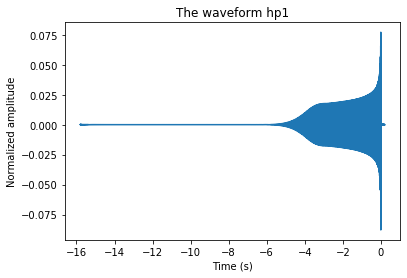

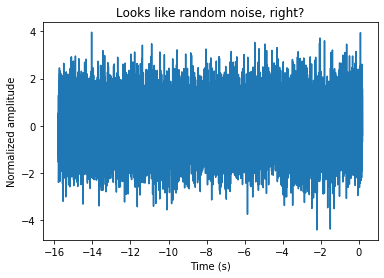

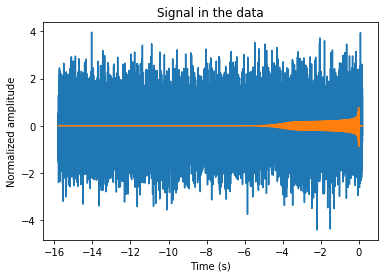

In [3]:
from pycbc.waveform import get_td_waveform

apx = 'IMRPhenomD'

hp1, _ = get_td_waveform(approximant=apx,
                         mass1=10,
                         mass2=10,
                         delta_t=1.0/sample_rate,
                         f_lower=25)

# The amplitude of gravitational-wave signals is normally of order 1E-20. To demonstrate our method
# on white noise with amplitude O(1) we normalize our signal so the cross-correlation of the signal with
# itself will give a value of 1. In this case we can interpret the cross-correlation of the signal with white
# noise as a signal-to-noise ratio.

hp1 = hp1 / max(numpy.correlate(hp1,hp1, mode='full'))**0.5

pylab.figure()
pylab.title("The waveform hp1")
pylab.plot(hp1.sample_times, hp1)
pylab.xlabel('Time (s)')
pylab.ylabel('Normalized amplitude')

waveform_start = numpy.random.randint(0, len(data) - len(hp1))
data[waveform_start:waveform_start+len(hp1)] += 10 * hp1.numpy()

pylab.figure()
pylab.title("Looks like random noise, right?")
pylab.plot(hp1.sample_times, data[waveform_start:waveform_start+len(hp1)])
pylab.xlabel('Time (s)')
pylab.ylabel('Normalized amplitude')

pylab.figure()
pylab.title("Signal in the data")
pylab.plot(hp1.sample_times, data[waveform_start:waveform_start+len(hp1)])
pylab.plot(hp1.sample_times, 10 * hp1)
pylab.xlabel('Time (s)')
pylab.ylabel('Normalized amplitude')




To search for this signal we can cross-correlate the signal with the entire dataset -> Not in any way optimized at this point, just showing the method

Text(0, 0.5, 'Cross-correlation')

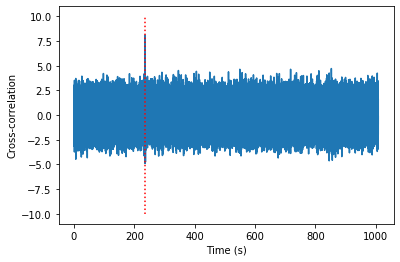

In [4]:
cross_correlation = numpy.zeros([len(data)-len(hp1)])
hp1_numpy = hp1.numpy()
for i in range(len(data) - len(hp1_numpy)):
    cross_correlation[i] = (hp1_numpy * data[i:i+len(hp1_numpy)]).sum()

pylab.figure()
times = numpy.arange(len(data) - len(hp1_numpy)) / float(sample_rate)
pylab.plot(times, cross_correlation)
pylab.plot([waveform_start/float(sample_rate), waveform_start/float(sample_rate)], [-10,10],'r:')
pylab.xlabel('Time (s)')
pylab.ylabel('Cross-correlation')



Here you can see that the largest spike from the cross-correlation comes at the time of the signal. We only really need one more ingredient to describe matched-filtering: Colored noise. Let's repeat the process, but generate a stretch of data colored with LIGO's zero-detuned--high-power noise curve. We'll use a PyCBC library to do this.

In [0]:
# http://pycbc.org/pycbc/latest/html/noise.html
import pycbc.noise
import pycbc.psd

# The color of the noise matches a PSD which you provide:
# Generate a PSD matching Advanced LIGO's zero-detuned--high-power noise curve 
flow = 10.0
delta_f = 1.0 / 128
flen = int(sample_rate / (2 * delta_f)) + 1
psd = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, flow)

# Generate colored noise
delta_t = 1.0 / sample_rate
ts = pycbc.noise.noise_from_psd(data_length*sample_rate, delta_t, psd, seed=127)
ts[waveform_start:waveform_start+len(hp1)] += hp1.numpy() * 1E-20



Then all we need to do is to "whiten" both the data, and the template waveform. This can be done, in the frequency domain, by dividing by the PSD. This *can* be done in the time domain as well, but it's more intuitive in the frequency domain

In [0]:
# Generate a PSD for whitening the data
from pycbc.types import TimeSeries
flow = 10.0
delta_f = 1.0 / data_length
flen = int(sample_rate / (2 * delta_f)) + 1
psd_td = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, 0)
delta_f = sample_rate / float(len(hp1))
flen = int(sample_rate / (2 * delta_f)) + 1
psd_hp1 = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, 0)

# Set 0th and Nth value to avoid inf
psd_td[0] = psd_td[1]
psd_td[len(psd_td) - 1] = psd_td[len(psd_td) - 2]

psd_hp1[0] = psd_hp1[1]
psd_hp1[len(psd_hp1) - 1] = psd_hp1[len(psd_hp1) - 2]

data_whitened = (ts.to_frequencyseries() / psd_td**0.5).to_timeseries()
hp1_whitened = (hp1.to_frequencyseries() / psd_hp1**0.5).to_timeseries() * 1E-21


Text(0, 0.5, 'Cross-correlation')

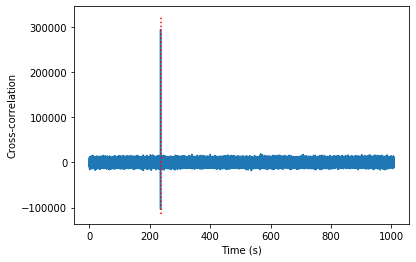

In [7]:
cross_correlation = numpy.zeros([len(data)-len(hp1)])
hp1n = hp1_whitened.numpy()
datan = data_whitened.numpy()
for i in range(len(datan) - len(hp1n)):
    cross_correlation[i] = (hp1n * datan[i:i+len(hp1n)]).sum()

pylab.figure()
times = numpy.arange(len(datan) - len(hp1n)) / float(sample_rate)
pylab.plot(times, cross_correlation)
pylab.plot([waveform_start/float(sample_rate), waveform_start/float(sample_rate)],
           [(min(cross_correlation))*1.1,(max(cross_correlation))*1.1],'r:')
pylab.xlabel('Time (s)')
pylab.ylabel('Cross-correlation')



### Optimizing a matched-filter

That's all that a matched-filter is. A cross-correlation of the data with a template waveform performed as a function of time. This cross-correlation walking through the data is a convolution operation. Convolution operations are more optimally performed in the frequency domain, which becomes a `O(N ln N)` operation, as opposed to the `O(N^2)` operation shown here. You can also conveniently vary the phase of the signal in the frequency domain, as we will illustrate in the next tutorial. PyCBC implements a frequency-domain matched-filtering engine, which is much faster than the code we've shown here. Let's move to the next tutorial now, where we will demonstrate its use on real data.